# Modelado

In [1]:
import pandas as pd
import numpy as np

In [2]:
import re
import string
import nltk

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Descargar recursos de NLTK
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [90]:
# 📌 2. Cargar Datos
df = pd.read_csv("../data/processed/reclamos_descripciones.csv")

### PREPARACIÓN DE LOS DATOS

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162639 entries, 0 to 162638
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   ID_PERIODO             162639 non-null  int64 
 1   DE_TIPO_ADMINISTRADO   162639 non-null  object
 2   DE_TIPO_INSTITUCION    162639 non-null  object
 3   DE_MEDIO_PRESENTACION  162639 non-null  object
 4   CO_UNICO_RECLAMO       162639 non-null  object
 5   DE_MEDIO_RECEPCION     162639 non-null  object
 6   FE_PRESEN_RECLA        162639 non-null  object
 7   DE_SERVICIO            162639 non-null  object
 8   DE_COMPETENCIA         162639 non-null  object
 9   DE_CLASIF_1            162639 non-null  object
 10  DE_CLASIF_2            162639 non-null  object
 11  DE_CLASIF_3            162639 non-null  object
 12  DE_ESTADO_RECLAMO      162639 non-null  object
 13  DE_ETAPA_RECLAMO       162639 non-null  object
 14  DE_TIPO_ADMIN_DERIVA   162639 non-null  object
 15  

In [ ]:
# Eliminar filas con valores nulos en 'FE_NOTIFI_RESULT' y 'DESCRIPCION'
# df = df.dropna(subset=['FE_NOTIFI_RESULT', 'DESCRIPCION'])

In [92]:
print(df['DESCRIPCION'].isnull().sum())
print(df['FE_NOTIFI_RESULT'].isnull().sum())

63269
97422


In [ ]:
df['FE_NOTIFI_RESULT'] = df['FE_NOTIFI_RESULT'].fillna('No notificado')
df['DESCRIPCION'] = df['DESCRIPCION'].fillna('No disponible')

In [24]:
### Eliminación de variables no necesarias

In [93]:
columns_delete = [
    'ID_PERIODO',
    #'CO_ADMIN_DECLA',
    #'CO_UGIPRESS',
    #'CO_ADMIN_SUCE',
    'DE_CLASIF_2',
    'DE_CLASIF_3',
    'CO_UNICO_RECLAMO',
    #'CO_RECLAMO_PRIMIG',
    'DE_MOTIVO_CONCL_ANTIC'
]

In [94]:
df = df.drop(columns=columns_delete)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162639 entries, 0 to 162638
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   DE_TIPO_ADMINISTRADO   162639 non-null  object
 1   DE_TIPO_INSTITUCION    162639 non-null  object
 2   DE_MEDIO_PRESENTACION  162639 non-null  object
 3   DE_MEDIO_RECEPCION     162639 non-null  object
 4   FE_PRESEN_RECLA        162639 non-null  object
 5   DE_SERVICIO            162639 non-null  object
 6   DE_COMPETENCIA         162639 non-null  object
 7   DE_CLASIF_1            162639 non-null  object
 8   DE_ESTADO_RECLAMO      162639 non-null  object
 9   DE_ETAPA_RECLAMO       162639 non-null  object
 10  DE_TIPO_ADMIN_DERIVA   162639 non-null  object
 11  DE_RESULTADO           162639 non-null  object
 12  FE_RESULT_RECL         162639 non-null  object
 13  DE_COMUN_RESULT        162639 non-null  object
 14  FE_NOTIFI_RESULT       65217 non-null   object
 15  

### Datos categoricos 

In [96]:
print(df.dtypes)

DE_TIPO_ADMINISTRADO     object
DE_TIPO_INSTITUCION      object
DE_MEDIO_PRESENTACION    object
DE_MEDIO_RECEPCION       object
FE_PRESEN_RECLA          object
DE_SERVICIO              object
DE_COMPETENCIA           object
DE_CLASIF_1              object
DE_ESTADO_RECLAMO        object
DE_ETAPA_RECLAMO         object
DE_TIPO_ADMIN_DERIVA     object
DE_RESULTADO             object
FE_RESULT_RECL           object
DE_COMUN_RESULT          object
FE_NOTIFI_RESULT         object
AÑO                       int64
MES                       int64
DURACION_RECLAMO          int64
CATEGORIA_DURACION       object
DESCRIPCION              object
dtype: object


In [49]:
df['DE_COMPETENCIA'].dtype

dtype('O')

In [ ]:
pd.get_dummies(df['DE_MEDIO_PRESENTACION'])

### Categorias para codificarlas

In [97]:
# 1. Identify categorical columns
categorical_columns = [
    'DE_TIPO_ADMINISTRADO', 'DE_TIPO_INSTITUCION', 'DE_MEDIO_PRESENTACION',
    'DE_MEDIO_RECEPCION', 'DE_SERVICIO', 'DE_COMPETENCIA',
    'DE_CLASIF_1', 'DE_ESTADO_RECLAMO',
    'DE_ETAPA_RECLAMO', 'DE_TIPO_ADMIN_DERIVA', 'DE_RESULTADO',
    'DE_COMUN_RESULT'
]

In [98]:
# 2. Apply one-hot encoding using pandas get_dummies
df_encoded = pd.get_dummies(
    df,
    columns=categorical_columns,
    prefix=categorical_columns,
    prefix_sep='_',
    drop_first=True  # Drop first category to avoid multicollinearity
)

In [99]:
# 3. Handle datetime columns separately
df_encoded['FE_PRESEN_RECLA'] = pd.to_datetime(df_encoded['FE_PRESEN_RECLA'])
df_encoded['FE_RESULT_RECL'] = pd.to_datetime(df_encoded['FE_RESULT_RECL'])
df_encoded['FE_NOTIFI_RESULT'] = pd.to_datetime(df_encoded['FE_NOTIFI_RESULT'])


In [100]:
# Extract useful features from dates
for date_col in ['FE_PRESEN_RECLA', 'FE_RESULT_RECL', 'FE_NOTIFI_RESULT']:
    df_encoded[f'{date_col}_year'] = df_encoded[date_col].dt.year
    df_encoded[f'{date_col}_month'] = df_encoded[date_col].dt.month
    df_encoded[f'{date_col}_day'] = df_encoded[date_col].dt.day
    df_encoded = df_encoded.drop(columns=[date_col])

In [101]:
# 4. Print shape before and after encoding
print(f"Shape before encoding: {df.shape}")
print(f"Shape after encoding: {df_encoded.shape}")

Shape before encoding: (162639, 20)
Shape after encoding: (162639, 81)


In [102]:
# 5. Verify some of the new columns
print("\nSample of new encoded columns:")
print(df_encoded.columns[:10])


Sample of new encoded columns:
Index(['AÑO', 'MES', 'DURACION_RECLAMO', 'CATEGORIA_DURACION', 'DESCRIPCION',
       'DE_TIPO_INSTITUCION_IPRESS', 'DE_TIPO_INSTITUCION_UGIPRESS',
       'DE_MEDIO_PRESENTACION_Teléfonic', 'DE_MEDIO_PRESENTACION_Teléfonico',
       'DE_MEDIO_PRESENTACION_Virtual'],
      dtype='object')


In [103]:
# 6. Save encoded DataFrame if needed
df_encoded.to_csv('../data/processed/reclamos_encoded.csv', index=False)

In [104]:
# Check number of unique categories in original vs encoded data
for col in categorical_columns:
    n_categories = len(df[col].unique())
    n_encoded = sum(1 for c in df_encoded.columns if c.startswith(f"{col}_"))
    print(f"{col}: {n_categories} categories -> {n_encoded} encoded columns")

DE_TIPO_ADMINISTRADO: 1 categories -> 0 encoded columns
DE_TIPO_INSTITUCION: 3 categories -> 2 encoded columns
DE_MEDIO_PRESENTACION: 4 categories -> 3 encoded columns
DE_MEDIO_RECEPCION: 7 categories -> 6 encoded columns
DE_SERVICIO: 15 categories -> 14 encoded columns
DE_COMPETENCIA: 3 categories -> 2 encoded columns
DE_CLASIF_1: 18 categories -> 17 encoded columns
DE_ESTADO_RECLAMO: 6 categories -> 5 encoded columns
DE_ETAPA_RECLAMO: 5 categories -> 4 encoded columns
DE_TIPO_ADMIN_DERIVA: 4 categories -> 3 encoded columns
DE_RESULTADO: 7 categories -> 6 encoded columns
DE_COMUN_RESULT: 6 categories -> 5 encoded columns


### Preprocesamiento de datos de texto (DESCRIPCION)

In [69]:
def clean_text(text):
    """
    Clean text by:
    1. Converting to lowercase
    2. Removing special characters and punctuation
    3. Removing stopwords
    4. Removing extra whitespace
    """
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [70]:
# Apply cleaning to DESCRIPCION column
df['DESCRIPCION_clean'] = df['DESCRIPCION'].apply(clean_text)

In [72]:
# Show sample results
print("Muestra de textos originales vs. limpios:")
for original, limpio in zip(df['DESCRIPCION'].head(), df['DESCRIPCION_clean'].head()):
    print("\nOriginal:", original)
    print("Limpio:", limpio)

Muestra de textos originales vs. limpios:

Original: Mi solicitud para recibir servicio de salud médico fue retrasada sin una justificación clara.
Limpio: solicitud recibir servicio salud médico retrasada justificación clara

Original: me cobró por una cirugía de emergencia que, como asegurado, debería estar cubierta.
Limpio: cobró cirugía emergencia asegurado debería cubierta

Original: Recibí un servicio deficiente de parte de la IAFAS.
Limpio: recibí servicio deficiente parte iafas

Original: El policlínico de mi zona no cuenta con traumatólogo, pese a ser una especialidad básica.
Limpio: policlínico zona cuenta traumatólogo pese ser especialidad básica

Original: Recibí un servicio deficiente de parte de la IAFAS.
Limpio: recibí servicio deficiente parte iafas


In [74]:
# Print basic statistics
print(f"\nNúmero de descripciones vacías: {df['DESCRIPCION_clean'].isna().sum()}")
print(f"Longitud promedio (palabras): {df['DESCRIPCION_clean'].str.split().str.len().mean():.2f}")


Número de descripciones vacías: 0
Longitud promedio (palabras): 3.86


### Construcción de la variable de urgencia (PRIORIDAD)

In [75]:
df['DE_SERVICIO'].unique()

array(['-', 'Farmacia',
       'Oficinas o áreas administrativas de IAFAS o IPRESS o UGIPRESS',
       'Servicios Médicos de Apoyo', 'Consulta Externa',
       'Hospitalización', 'Atención a domicilio, urgencia o emergencia',
       'Atención a domicilio, consulta ambulatoria', 'Emergencia',
       'Centro Quirúrgico', 'UCI o UCIN', 'Infraestructura',
       'Referencia y Contrareferencia', 'Centro Obstétrico',
       'Oficinas o áreas administrativas de IAFAS o IPRESS o UGIPRES'],
      dtype=object)

In [77]:
def asignar_prioridad(row):
    """
    Asigna prioridad basada en el servicio y duración del reclamo
    Alta: Servicios críticos o reclamos que duran más de 30 días
    Media: Servicios de atención directa
    Baja: Servicios administrativos y otros
    """
    servicios_alta = [
        'UCI o UCIN',
        'Emergencia',
        'Centro Quirúrgico',
        'Centro Obstétrico'
    ]
    
    servicios_media = [
        'Hospitalización',
        'Atención a domicilio, urgencia o emergencia',
        'Consulta Externa',
        'Referencia y Contrareferencia',
        'Atención a domicilio, consulta ambulatoria'
    ]
    
    if row['DURACION_RECLAMO'] > 30:
        return 'Alta'
    elif row['DE_SERVICIO'] in servicios_alta:
        return 'Alta'
    elif row['DE_SERVICIO'] in servicios_media:
        return 'Media'
    else:
        return 'Baja'

In [78]:
# Aplicar la función y crear nueva columna
df['PRIORIDAD'] = df.apply(asignar_prioridad, axis=1)


In [79]:
# Verificar la distribución de prioridades
print("Distribución de prioridades:")
print(df['PRIORIDAD'].value_counts())

Distribución de prioridades:
PRIORIDAD
Baja     139402
Alta      19183
Media      4054
Name: count, dtype: int64


In [80]:
# Mostrar ejemplos de cada prioridad
print("\nEjemplos de reclamos por prioridad:")
for prioridad in ['Alta', 'Media', 'Baja']:
    print(f"\nPrioridad {prioridad}:")
    muestra = df[df['PRIORIDAD'] == prioridad][['DE_SERVICIO', 'DURACION_RECLAMO', 'PRIORIDAD']].head(3)
    print(muestra.to_string())


Ejemplos de reclamos por prioridad:

Prioridad Alta:
   DE_SERVICIO  DURACION_RECLAMO PRIORIDAD
1            -                45      Alta
9            -                45      Alta
86           -                31      Alta

Prioridad Media:
                                      DE_SERVICIO  DURACION_RECLAMO PRIORIDAD
1613                             Consulta Externa                 0     Media
1614                             Consulta Externa                 0     Media
1622  Atención a domicilio, urgencia o emergencia                 0     Media

Prioridad Baja:
  DE_SERVICIO  DURACION_RECLAMO PRIORIDAD
0           -                24      Baja
2           -                14      Baja
3           -                19      Baja


In [50]:
####

In [4]:
# 📌 3. Preprocesamiento de Texto
def limpiar_texto(texto):
    texto = texto.lower()  # Minúsculas
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    tokens = word_tokenize(texto)  # Tokenización
    tokens = [word for word in tokens if word not in stopwords.words("spanish")]  # Eliminar stopwords
    return " ".join(tokens)

In [5]:
df["texto_limpio"] = df["DESCRIPCION"].dropna().apply(limpiar_texto)

In [12]:
# Clean NaN values and convert to string
df["texto_limpio"] = df["texto_limpio"].fillna("")

# Verify there are no NaN values
print("Number of NaN values:", df["texto_limpio"].isna().sum())

# 📌 4. Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["texto_limpio"])

Number of NaN values: 0


In [13]:
# 📌 4. Convertir texto a vectores TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["texto_limpio"])

In [14]:
# 📌 5. Definir la variable objetivo (Clasificador)
y = df["DE_CLASIF_1"]  # Asegúrate de que esta columna existe

In [15]:
# 📌 6. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 📌 7. Entrenar modelo Naïve Bayes
modelo = MultinomialNB()
modelo.fit(X_train, y_train)

MultinomialNB()

In [17]:
# 📌 8. Evaluar Modelo
y_pred = modelo.predict(X_test)

In [18]:
# 📌 9. Métricas de evaluación
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))

Exactitud (Accuracy): 0.9661214953271028


c:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Reporte de Clasificación:
                                                                                   precision    recall  f1-score   support

                                                                               -       0.99      1.00      1.00     12640
                                                            Cobrar indebidamente       1.00      1.00      1.00      2107
                      Demorar la gestión de la carta de garantía y/o reembolsos.       0.00      0.00      0.00      1030
                       Negar atención para el trámite de registro o acreditación       1.00      1.00      1.00       196
                     Negar el otorgamiento de prestaciones económicas o sociales       1.00      0.61      0.76        49
                                     Negar la acreditación de usuario asegurado.       0.68      1.00      0.81      2173
                                                 Negar la afiliación del usuario       1.00      0.90      0.95       

c:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


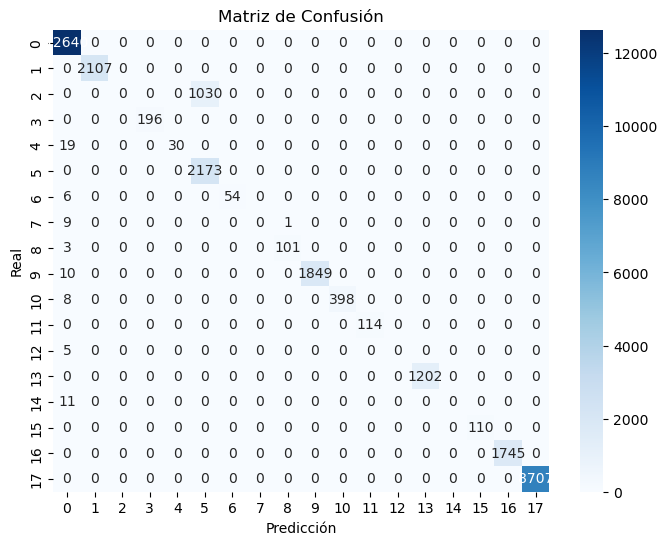

In [19]:
# 📌 10. Matriz de Confusión
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


In [20]:
# 📌 11. Función para clasificar nuevos reclamos
def predecir_clasificacion(texto):
    texto_procesado = limpiar_texto(texto)
    texto_vectorizado = vectorizer.transform([texto_procesado])
    return modelo.predict(texto_vectorizado)[0]

In [42]:
# 📌 12. Probar con un reclamo nuevo
nuevo_reclamo = "Cobro en farmacia"
print("Clasificación Predicha:", predecir_clasificacion(nuevo_reclamo))

Clasificación Predicha: Cobrar indebidamente
